**Mounting Google Drive for Dataset**

**Importing Libraries**

In [5]:
import numpy as np
import h5py
import math

from keras.models import Model
from keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv3D
from keras.layers import Lambda, Concatenate, MaxPooling2D, Maximum, Add
from keras.initializers import RandomNormal
from keras.optimizers import SGD
from keras.losses import MeanSquaredError
from keras.callbacks import Callback,LearningRateScheduler
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

**Util functions**

In [6]:
import h5py
import numpy as np
from tensorflow.keras.initializers import RandomNormal

# Load Dataset from Local Path
def load_train_dataset():
    """
    Load training dataset from local path

    Returns:
    clean_image -- Clean image patches
    haze_image -- Hazy image patches
    transmission_value -- Transmission value which converts clean image to 
                          haze image
    """

    file = r"C:\Users\adity\OneDrive\Desktop\211172\Major Project\Aditya\Jupyter Notebooks-20241129T163236Z-001\Jupyter Notebooks\train_data.hdf5"
    
    with h5py.File(file, 'r') as train_dataset:
        clean_image = np.array(train_dataset['clear_image'][:])
        haze_image = np.array(train_dataset['haze_image'][:])
        transmission_value = np.array(train_dataset['transmission_value'][:])
    
    return clean_image, haze_image, transmission_value


# Gaussian Weight Initialization for layers
weight_init = RandomNormal(mean=0.0, stddev=0.001)


# Learning Rate Decay function
def lr_schedule(epoch, lr, logs={}):
    """
    Learning Rate Decay scheduler

    Arguments:
    epoch -- current epoch number
    lr -- current learning rate
    log -- dictionary storing the logs of training

    Returns:
    lr -- learning rate for next epoch
    """

    print('learning_rate:', lr)
    logs.update({'lr': lr})
    if epoch in (49, 99):
        return lr * 0.5
    else:
        return lr


**Preparing Train Dataset**

In [7]:
clean_image, haze_image, transmission_value = load_train_dataset()
transmission_value = transmission_value.reshape(-1,1,1,1)

print ("number of training examples:", clean_image.shape[0])
print ("Clean Image Patch shape:", clean_image.shape)
print ("Haze Image Patch shape:", haze_image.shape)
print ("Transmission Value shape:", transmission_value.shape)

number of training examples: 60000
Clean Image Patch shape: (60000, 16, 16, 3)
Haze Image Patch shape: (60000, 16, 16, 3)
Transmission Value shape: (60000, 1, 1, 1)


#### Transmission Model

**Designing**

In [8]:
def TransmissionModel(input_shape):
    """
    Implementation of the Model.
    
    Arguments:
    input_shape -- shape of the images of the dataset
        (height, width, channels) as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]

    Returns:
    model -- a Model() instance in Keras
    """
    
    X_input = Input(input_shape, name = 'input1')

    # CONV -> RELU Block applied to X
    X = Conv2D(16, (3, 3), strides = (1, 1), kernel_initializer = weight_init, name = 'conv1')(X_input)
    X = Activation('relu', name = 'activation1')(X)

    # SLICE Block applied to X
    X1 = Lambda(lambda X: X[:,:,:,:4], name = 'slice1')(X)
    X2 = Lambda(lambda X: X[:,:,:,4:8], name = 'slice2')(X)
    X3 = Lambda(lambda X: X[:,:,:,8:12], name = 'slice3')(X)
    X4 = Lambda(lambda X: X[:,:,:,12:], name = 'slice4')(X)

    # MAXIMUM Block applied to 4 slices
    X = Maximum(name = 'merge1_maximum')([X1,X2,X3,X4])

    # CONV BLock for multi-scale mapping with filters of size 3x3, 5x5, 7x7
    X_3x3 = Conv2D(16, (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = weight_init, name = 'conv2_3x3')(X)
    X_5x5 = Conv2D(16, (5, 5), strides = (1, 1), padding = 'same', kernel_initializer = weight_init, name = 'conv2_5x5')(X)
    X_7x7 = Conv2D(16, (7, 7), strides = (1, 1), padding = 'same', kernel_initializer = weight_init, name = 'conv2_7x7')(X)

    # CONCATENATE Block to join 3 multi-scale layers
    X = Concatenate(name = 'merge2_concatenate')([X_3x3,X_5x5,X_7x7])

    # MAXPOOL layer of filter size 7x7
    X = MaxPooling2D((7, 7), strides = (1, 1), name = 'maxpool1')(X)
    
    # CONV -> RELU BLock
    X = Conv2D(1, (8, 8), strides = (1, 1), kernel_initializer = weight_init, name = 'conv3')(X)
    X = Activation('relu', name = 'activation2')(X)

    # Create Keras model instance
    model = Model(inputs = X_input, outputs = X, name='TransmissionModel')

    return model

**Compiling**

In [9]:
model1 = TransmissionModel(haze_image.shape[1:])
model1.summary()
model1.compile(optimizer=SGD(0.001), loss=MeanSquaredError())

C:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(



Model: "TransmissionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input1 (InputLayer)         [(None, 16, 16, 3)]          0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 14, 14, 16)           448       ['input1[0][0]']              
                                                                                                  
 activation1 (Activation)    (None, 14, 14, 16)           0         ['conv1[0][0]']               
                                                                                                  
 slice1 (Lambda)             (None, 14, 14, 4)            0         ['activation1[0][0]']         
                                                                                 

**Training**

In [11]:
history1 = model1.fit(haze_image, transmission_value, batch_size = 30, epochs = 150, callbacks=[LearningRateScheduler(lr_schedule)])

learning_rate: 0.0010000000474974513
Epoch 1/150

2000/2000 [==============================] - 12s 5ms/step - loss: 0.0644 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 2/150
2000/2000 [==============================] - 11s 5ms/step - loss: 0.0351 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 3/150
2000/2000 [==============================] - 11s 5ms/step - loss: 0.0351 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 4/150
2000/2000 [==============================] - 11s 5ms/step - loss: 0.0347 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 5/150
2000/2000 [==============================] - 10s 5ms/step - loss: 0.0306 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 6/150
2000/2000 [==============================] - 11s 5ms/step - loss: 0.0228 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 7/150
2000/2000 [==============================] - 11s 5ms/step - loss: 0.0208 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 8/150
2000/

**Generating Models and Graph**

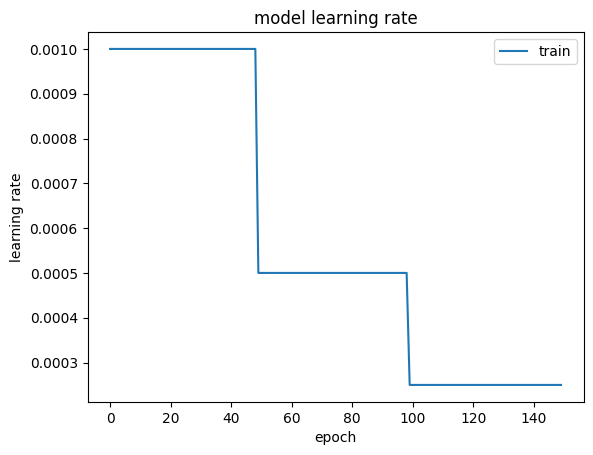

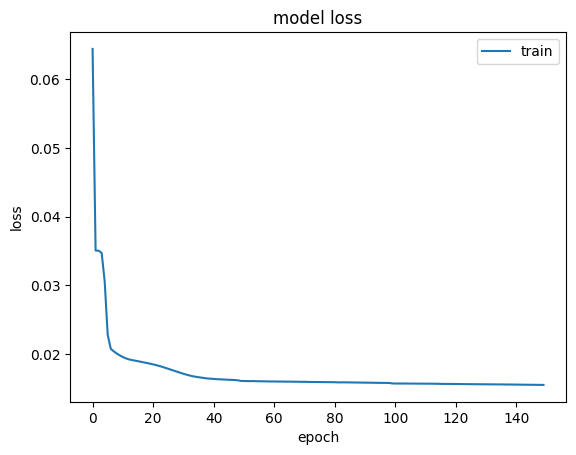

In [12]:
plt.plot(history1.history['lr'])
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.savefig('trans150-30-lr.png')
plt.show()
plt.plot(history1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.savefig('trans150-30-loss.png')
plt.show()

In [13]:
model1.save("transmodel_150_30.h5")
model1.save_weights('transmodel_150_30_weights.h5')

C:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
plot_model(model1, 'trans_model.png')
plot_model(model1, 'trans_model_shape.png', True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


**Predicting**

In [14]:
t = np.expand_dims(haze_image[500], axis=0)
print(model1.predict(t))
print(transmission_value[500])

1/1 [==============================] - 0s 247ms/step
[[[[0.3972692]]]]
[[[0.6]]]
